In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json
from PIL import Image
import PIL
import requests
from io import BytesIO

from imageModifiers import *
from projectionBreaks import *

matplotlib.rcParams["figure.figsize"] = (10, 10)

# Read in and prep data

In [2]:
subj = pd.read_csv("../data/ASM/anti-slavery-manuscripts-subjects.csv", low_memory=False)
subj["locations_dict"] = [json.loads(q) for q in subj["locations"]]
subj = subj[subj["subject_set_id"] == 15582]
subj = subj[subj["workflow_id"] == 5329]

In [3]:
image_locs = pd.DataFrame(columns = ["subject_id", "frame", "url"])

for i in range(len(subj)):
    subject_id = subj["subject_id"].iloc[i]
    locations = subj["locations_dict"].iloc[i]
    locs = pd.DataFrame({"frame":list(locations.keys()), "url":list(locations.values()), "subject_id":subject_id})
    image_locs = image_locs.append(locs)
    if i % 200 == 0: print(i, end="\t", flush=True)

image_locs.index = pd.RangeIndex(len(image_locs))

0	200	400	600	800	1000	1200	1400	1600	1800	2000	

# Segment an image

In [4]:
def readImg(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert("L")
    return img

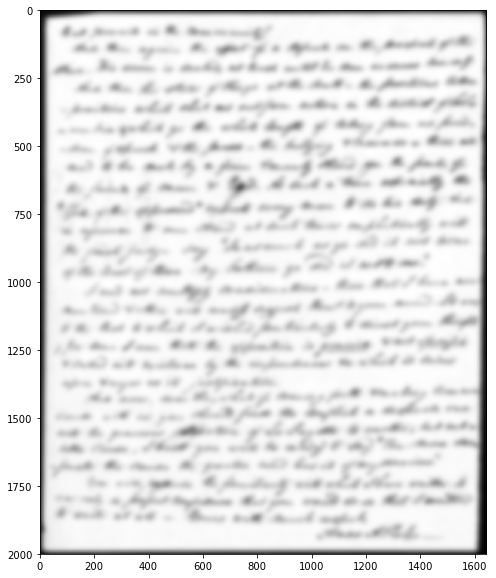

In [24]:
img_loc = image_locs["url"].iloc[50]
img = np.array(readImg(img_loc))
img_smooth = smoothImg(img, 10)
plt.imshow(img_smooth, cmap="gray")
plt.show()

In [45]:
img_width = img_smooth.shape[1]
slice_width = int(img_width/5.0)
shift_by = int(img_width/15.0)

# get linebreaks by sections
linebreaks = []
i = 0
for i in range(0, img_width-slice_width, shift_by):
    this_section = img_smooth[:, i:(i+slice_width)]
    lb = projBreaks(this_section, "y")
    linebreaks.append(lb)

# get closest linebreak for each section
linebreaks2 = []
for i in range(len(linebreaks[0])):
    l = linebreaks[0][i]
    lb = []
    lb.append(l)
    for j in range(1, len(linebreaks)):
        cur_lb = linebreaks[j]
        lb_diff = np.abs(np.subtract(cur_lb, l))
        lb.append(cur_lb[lb_diff.argmin()])
    linebreaks2.append(lb)

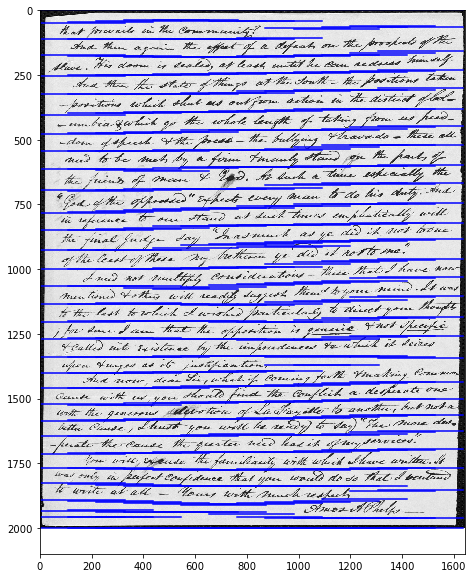

In [46]:
plt.imshow(img, cmap="gray")

count = 0
for i in range(0, img_width-slice_width, shift_by):
    lb = linebreaks[count]
    count += 1
    plt.plot([i,i+slice_width], [lb, lb], 'b')
plt.show()

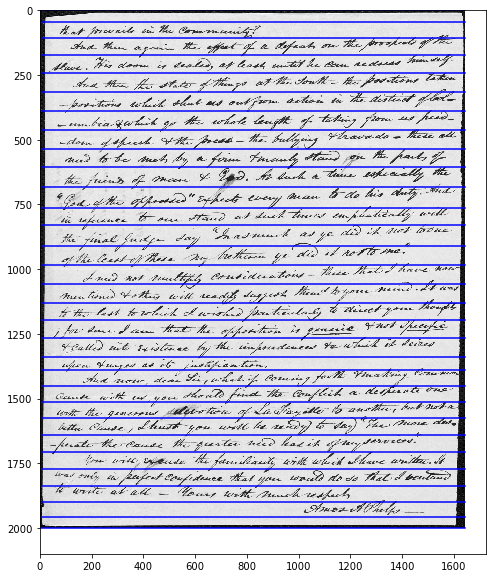

In [31]:
lb = projBreaks(img_smooth, "y")

plt.imshow(img, cmap="gray")
plt.plot([0,img.shape[1]], [lb, lb], 'b')
plt.show()